# Multi-Disease Prediction from Symptoms

This notebook trains an XGBoost classifier to predict diseases based on patient symptoms.

**Dataset:** 41 diseases with symptom combinations  
**Model:** XGBoost Multi-class Classifier  
**Features:** One-hot encoded symptoms

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import preprocessing
import xgboost as xgb
import joblib
import gzip

# Set plot styles
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


## 2. Load Dataset

In [2]:
# Load the raw dataset
dataset_df = pd.read_csv('../Frontend/data/dataset.csv')

print(f"Dataset shape: {dataset_df.shape}")
print(f"\nFirst few rows:")
display(dataset_df.head())

print(f"\nUnique diseases: {dataset_df['Disease'].nunique()}")
print(f"\nDisease distribution:")
print(dataset_df['Disease'].value_counts().head(10))

Dataset shape: (4930, 18)

First few rows:


,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Unique diseases: 42

Disease distribution:
Disease
Fungal infection                120
Hypothyroidism                  120
Hepatitis E                     120
Alcoholic hepatitis             120
Tuberculosis                    120
Common Cold                     120
Pneumonia                       120
Dimorphic hemmorhoids(piles)    120
Heart attack                    120
Varicose veins                  120
Name: count, dtype: int64


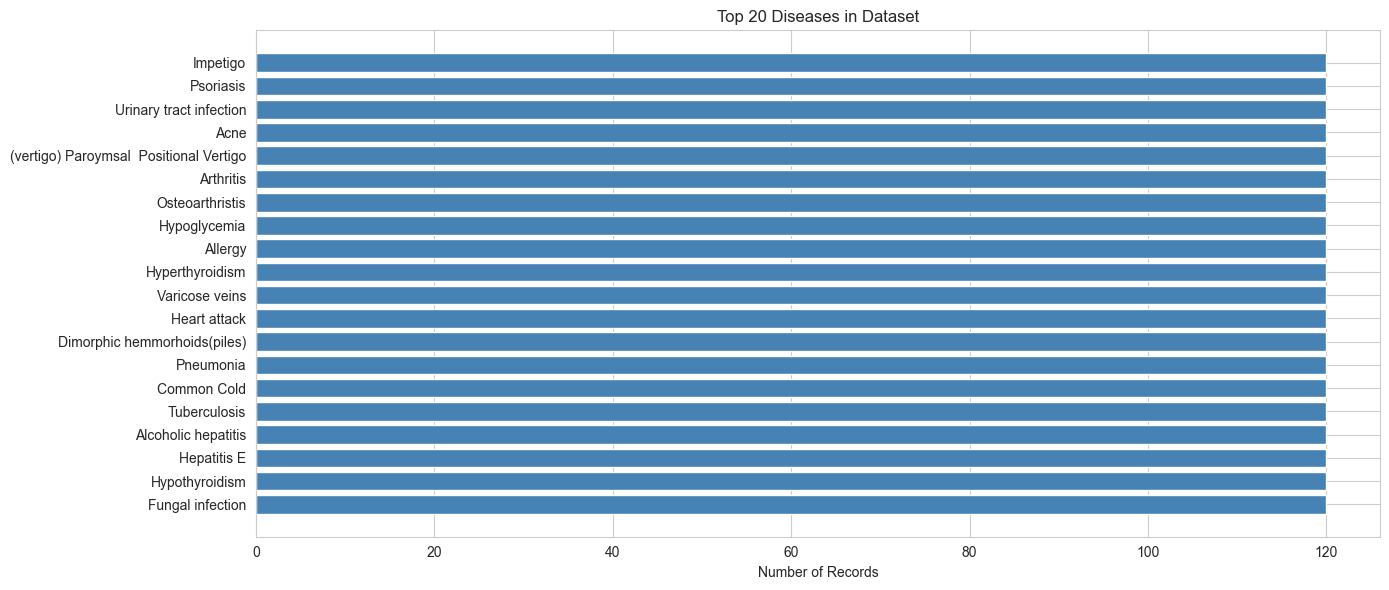

In [3]:
# Visualize disease distribution
plt.figure(figsize=(14, 6))
disease_counts = dataset_df['Disease'].value_counts().head(20)
plt.barh(disease_counts.index, disease_counts.values, color='steelblue')
plt.xlabel('Number of Records')
plt.title('Top 20 Diseases in Dataset')
plt.tight_layout()
plt.show()

## 3. Data Preprocessing

In [4]:
# Strip whitespace from all string columns
dataset_df = dataset_df.apply(lambda col: col.str.strip() if col.dtype == 'object' else col)

print("✓ Whitespace stripped from all columns")

✓ Whitespace stripped from all columns


In [5]:
# One-hot encode symptoms (all columns except Disease)
symptom_cols = [col for col in dataset_df.columns if col.startswith('Symptom')]
print(f"Encoding {len(symptom_cols)} symptom columns...")

# Get dummies for all symptom columns
test = pd.get_dummies(dataset_df.filter(regex='Symptom'), prefix='', prefix_sep='')

# Group by column name and take max (handles duplicate symptom columns)
test = test.groupby(test.columns, axis=1).agg(np.max)

print(f"\nOne-hot encoded shape: {test.shape}")
print(f"Total unique symptoms: {test.shape[1]}")

Encoding 17 symptom columns...

One-hot encoded shape: (4930, 133)
Total unique symptoms: 133


C:\Users\tan20\AppData\Local\Temp\ipykernel_18988\21426600.py:9: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  test = test.groupby(test.columns, axis=1).agg(np.max)
C:\Users\tan20\AppData\Local\Temp\ipykernel_18988\21426600.py:9: FutureWarning: The provided callable <function max at 0x000002487E3EAAC0> is currently using DataFrameGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  test = test.groupby(test.columns, axis=1).agg(np.max)


In [6]:
# Merge one-hot encoded symptoms with disease labels
clean_df = pd.merge(test, dataset_df['Disease'], left_index=True, right_index=True)

print(f"Clean dataset shape: {clean_df.shape}")
display(clean_df.head())

# Save cleaned dataset
clean_df.to_csv('../Frontend/data/clean_dataset.tsv', sep='\t', index=False)
print("\n✓ Clean dataset saved to: ../Frontend/data/clean_dataset.tsv")

Clean dataset shape: (4930, 134)


,abdominal_pain,abnormal_menstruation,acidity,acute_liver_failure,altered_sensorium,anxiety,back_pain,belly_pain,blackheads,bladder_discomfort,...,watering_from_eyes,weakness_in_limbs,weakness_of_one_body_side,weight_gain,weight_loss,yellow_crust_ooze,yellow_urine,yellowing_of_eyes,yellowish_skin,Disease
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Fungal infection
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Fungal infection
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Fungal infection
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Fungal infection
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Fungal infection



✓ Clean dataset saved to: ../Frontend/data/clean_dataset.tsv


## 4. Prepare Training Data

In [7]:
# Separate features and target
X_data = clean_df.iloc[:, :-1]  # All columns except last (Disease)
y_data = clean_df.iloc[:, -1]   # Disease column

print(f"Feature shape: {X_data.shape}")
print(f"Target shape: {y_data.shape}")
print(f"\nTarget classes: {y_data.nunique()}")

Feature shape: (4930, 133)
Target shape: (4930,)

Target classes: 42


In [8]:
# Convert disease names to categorical codes
y_data = y_data.astype('category')

# Fit label encoder
le = preprocessing.LabelEncoder()
le.fit(y_data)

print(f"Label encoder fitted with {len(le.classes_)} classes")
print(f"\nSample disease-to-code mapping:")
for i, disease in enumerate(le.classes_[:10]):
    print(f"  {i}: {disease}")

Label encoder fitted with 42 classes

Sample disease-to-code mapping:
  0: (vertigo) Paroymsal  Positional Vertigo
  1: AIDS
  2: Acne
  3: Alcoholic hepatitis
  4: Allergy
  5: Arthritis
  6: Bronchial Asthma
  7: Cervical spondylosis
  8: Chicken pox
  9: Chronic cholestasis


In [9]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, 
    test_size=0.2, 
    random_state=42
)

# Transform labels to numeric codes
y_train_encoded = le.transform(y_train)
y_test_encoded = le.transform(y_test)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (3944, 133)
Test set: (986, 133)


## 5. Train XGBoost Model

In [10]:
# Initialize XGBoost classifier
model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(le.classes_),
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    random_state=42
)

print("Training XGBoost classifier...\n")
model.fit(X_train, y_train_encoded)
print("✓ Model training complete!")

Training XGBoost classifier...

✓ Model training complete!
✓ Model training complete!


## 6. Model Evaluation

In [11]:
# Make predictions
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"="*60)
print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"="*60)

Test Accuracy: 1.0000 (100.00%)


In [12]:
# Classification report
print("\nClassification Report:")
print("="*60)
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_, zero_division=0))


Classification Report:
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        20
                                   AIDS       1.00      1.00      1.00        32
                                   Acne       1.00      1.00      1.00        22
                    Alcoholic hepatitis       1.00      1.00      1.00        24
                                Allergy       1.00      1.00      1.00        25
                              Arthritis       1.00      1.00      1.00        20
                       Bronchial Asthma       1.00      1.00      1.00        25
                   Cervical spondylosis       1.00      1.00      1.00        25
                            Chicken pox       1.00      1.00      1.00        26
                    Chronic cholestasis       1.00      1.00      1.00        23
                            Common Cold       1.00      1.00      1.00        22
   

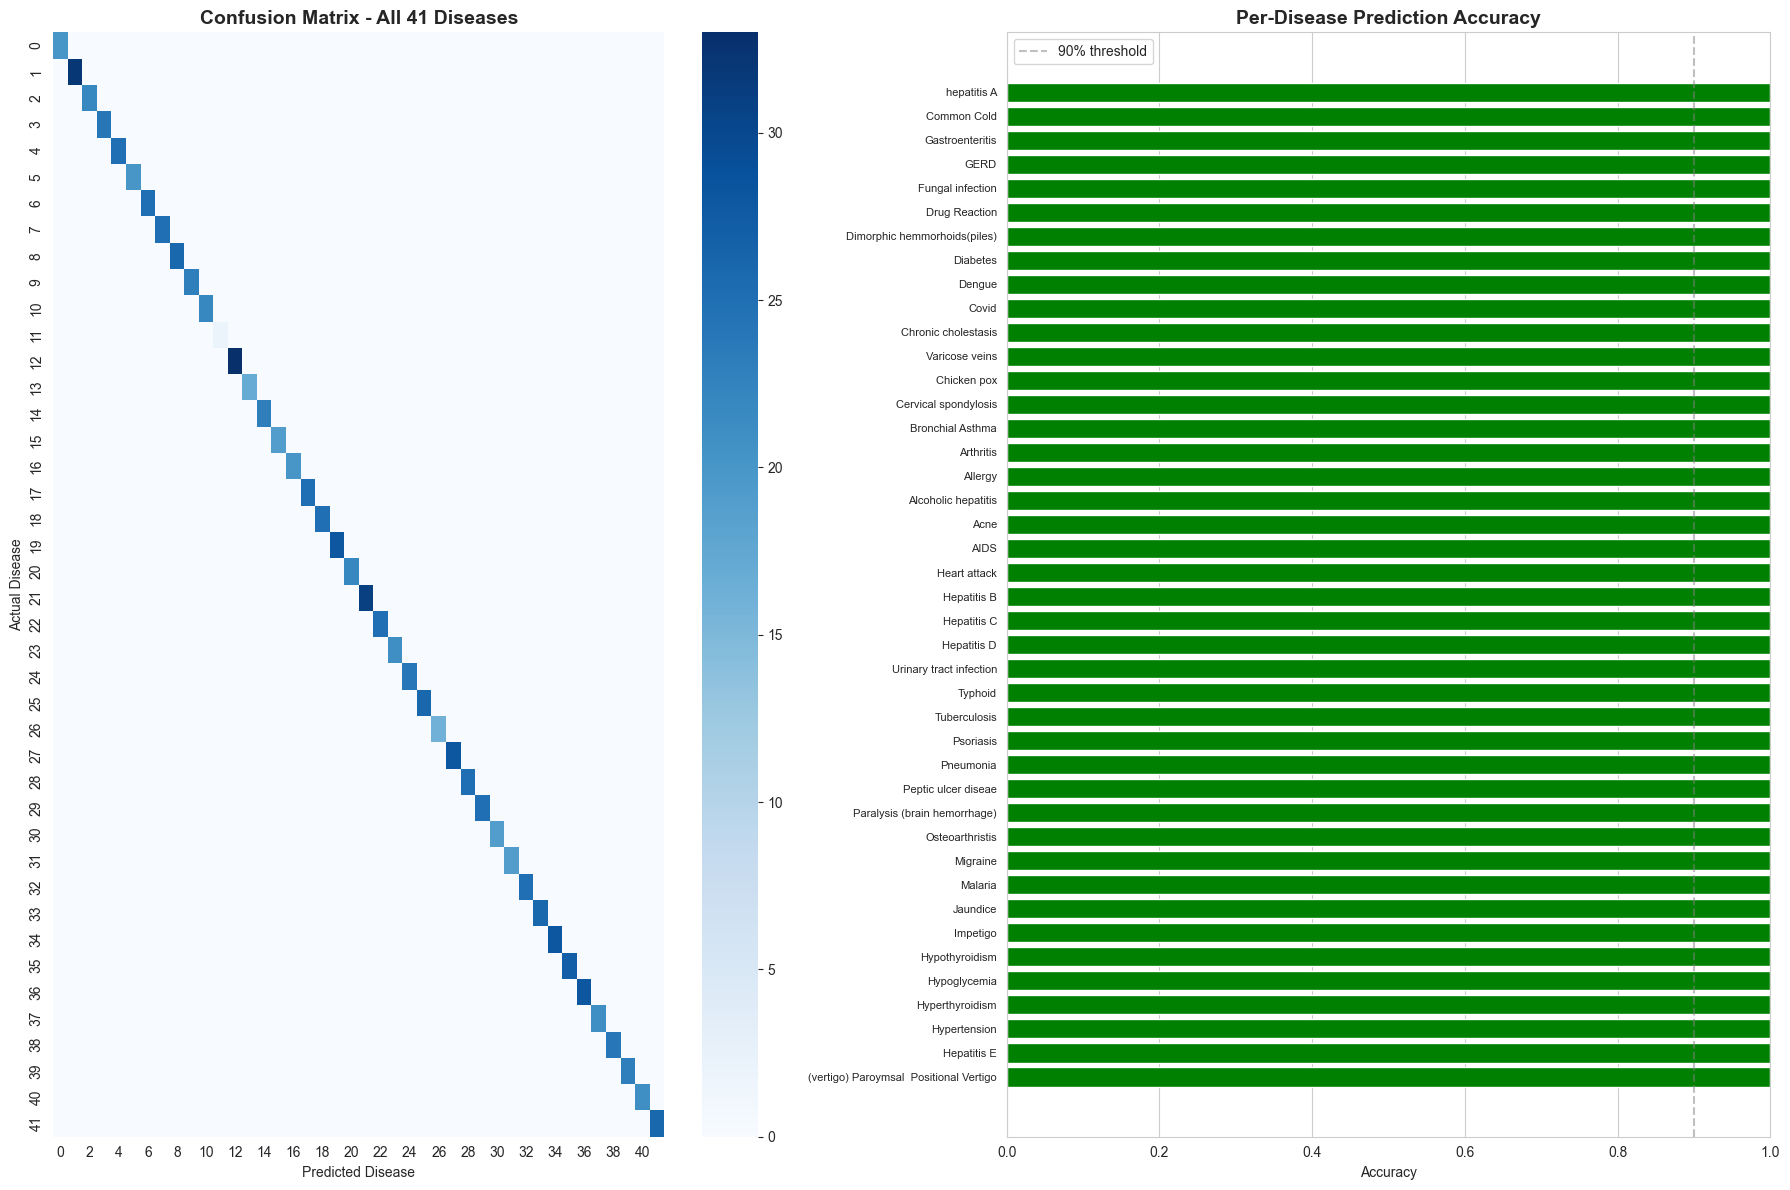


Confusion matrix shape: (42, 42)
Mean per-class accuracy: 1.0000
Diseases with <70% accuracy: 0


In [13]:
# Confusion matrix visualization
cm = confusion_matrix(y_test_encoded, y_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 12))

# Full confusion matrix (without annotations for clarity)
sns.heatmap(cm, annot=False, cmap='Blues', cbar=True, ax=ax1)
ax1.set_title('Confusion Matrix - All 41 Diseases', fontsize=14, fontweight='bold')
ax1.set_ylabel('Actual Disease')
ax1.set_xlabel('Predicted Disease')

# Diagonal values (correct predictions)
diagonal_accuracy = np.diag(cm) / cm.sum(axis=1)
sorted_idx = np.argsort(diagonal_accuracy)
sorted_diseases = le.classes_[sorted_idx]
sorted_accuracy = diagonal_accuracy[sorted_idx]

# Per-class accuracy
colors = ['red' if acc < 0.7 else 'orange' if acc < 0.9 else 'green' for acc in sorted_accuracy]
ax2.barh(range(len(sorted_diseases)), sorted_accuracy, color=colors)
ax2.set_yticks(range(len(sorted_diseases)))
ax2.set_yticklabels(sorted_diseases, fontsize=8)
ax2.set_xlabel('Accuracy')
ax2.set_title('Per-Disease Prediction Accuracy', fontsize=14, fontweight='bold')
ax2.axvline(x=0.9, color='gray', linestyle='--', alpha=0.5, label='90% threshold')
ax2.legend()
ax2.set_xlim([0, 1])

plt.tight_layout()
plt.show()

print(f"\nConfusion matrix shape: {cm.shape}")
print(f"Mean per-class accuracy: {diagonal_accuracy.mean():.4f}")
print(f"Diseases with <70% accuracy: {(diagonal_accuracy < 0.7).sum()}")

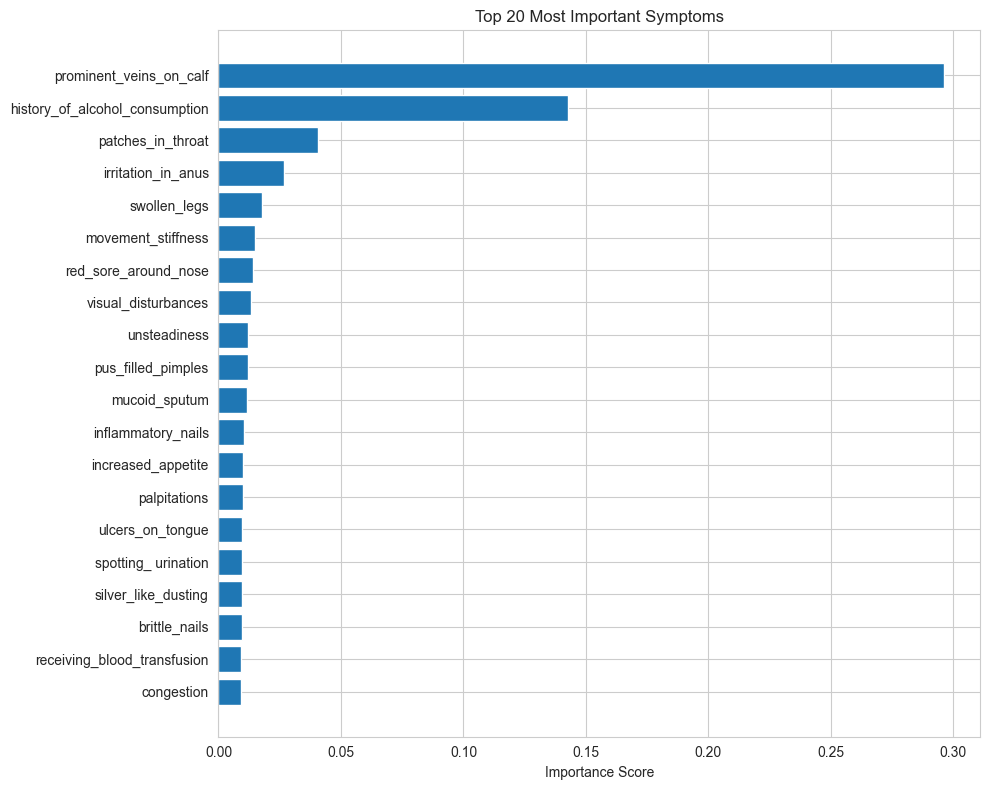


Top 10 most important symptoms:
                       symptom  importance
       prominent_veins_on_calf    0.296056
history_of_alcohol_consumption    0.142747
             patches_in_throat    0.040441
            irritation_in_anus    0.026718
                  swollen_legs    0.017964
            movement_stiffness    0.014851
          red_sore_around_nose    0.013891
           visual_disturbances    0.013206
                  unsteadiness    0.012194
            pus_filled_pimples    0.012152


In [14]:
# Feature importance (top 20 symptoms)
feature_importance = pd.DataFrame({
    'symptom': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
top_features = feature_importance.head(20)
plt.barh(top_features['symptom'], top_features['importance'])
plt.xlabel('Importance Score')
plt.title('Top 20 Most Important Symptoms')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 most important symptoms:")
print(feature_importance.head(10).to_string(index=False))

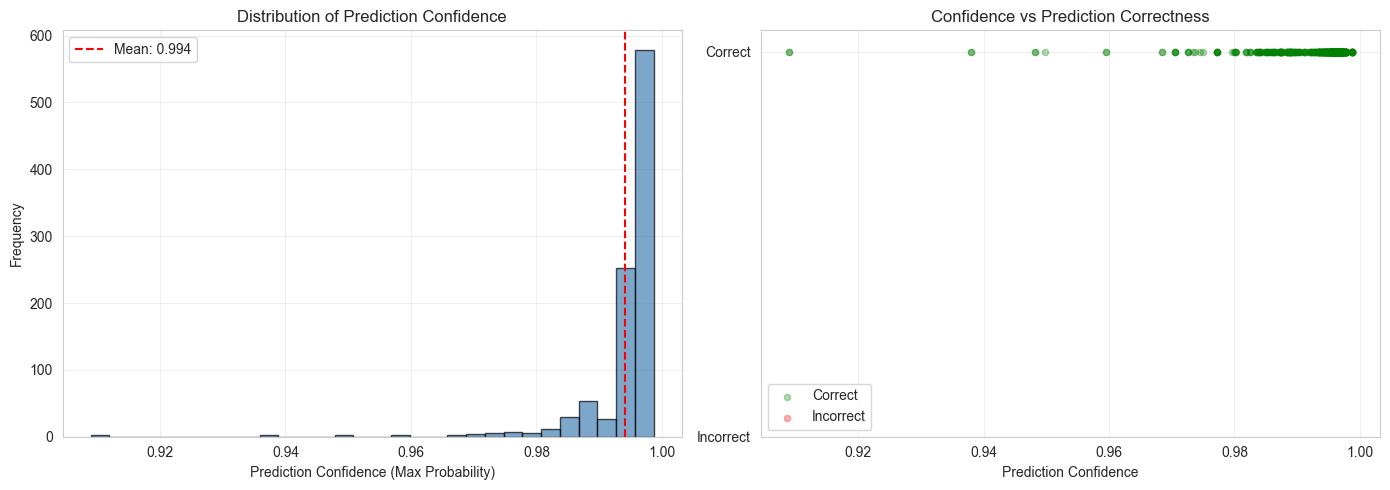


Prediction Confidence Statistics:
  Mean confidence: 0.9942
  Median confidence: 0.9964
  High confidence (>0.9): 986/986 (100.0%)


In [15]:
# Analyze prediction confidence
y_proba = model.predict_proba(X_test)
max_probabilities = np.max(y_proba, axis=1)
correct_predictions = (y_pred == y_test_encoded)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confidence distribution
axes[0].hist(max_probabilities, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(max_probabilities.mean(), color='red', linestyle='--', 
                label=f'Mean: {max_probabilities.mean():.3f}')
axes[0].set_xlabel('Prediction Confidence (Max Probability)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Prediction Confidence')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Confidence vs Correctness
axes[1].scatter(max_probabilities[correct_predictions], 
                np.ones(correct_predictions.sum()), 
                alpha=0.3, c='green', label='Correct', s=20)
axes[1].scatter(max_probabilities[~correct_predictions], 
                np.zeros((~correct_predictions).sum()), 
                alpha=0.3, c='red', label='Incorrect', s=20)
axes[1].set_xlabel('Prediction Confidence')
axes[1].set_yticks([0, 1])
axes[1].set_yticklabels(['Incorrect', 'Correct'])
axes[1].set_title('Confidence vs Prediction Correctness')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPrediction Confidence Statistics:")
print(f"  Mean confidence: {max_probabilities.mean():.4f}")
print(f"  Median confidence: {np.median(max_probabilities):.4f}")
print(f"  High confidence (>0.9): {(max_probabilities > 0.9).sum()}/{len(max_probabilities)} ({(max_probabilities > 0.9).sum()/len(max_probabilities)*100:.1f}%)")

### Prediction Confidence Analysis

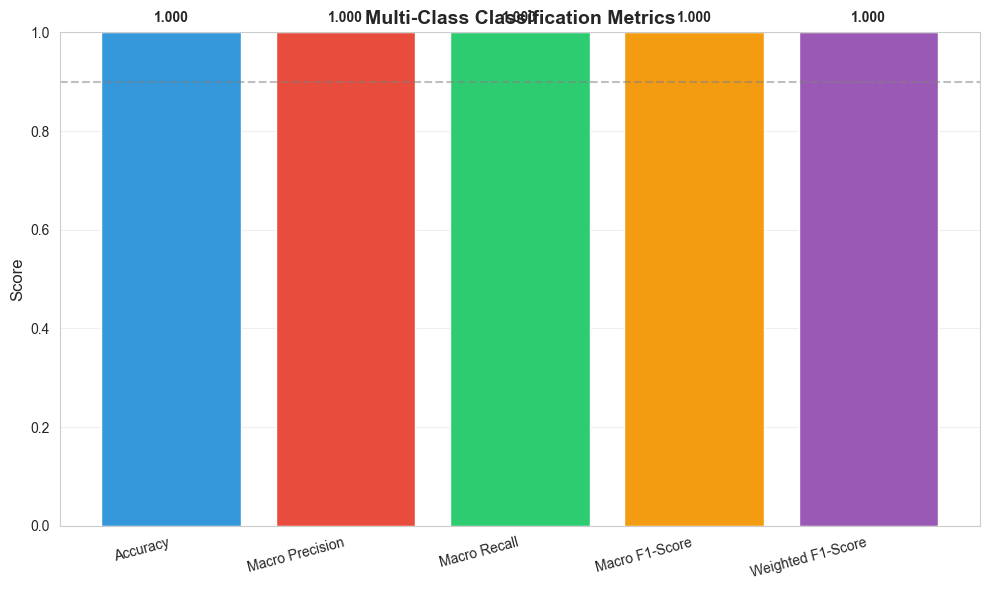


Detailed Metrics:
  Accuracy            : 1.0000
  Macro Precision     : 1.0000
  Macro Recall        : 1.0000
  Macro F1-Score      : 1.0000
  Weighted F1-Score   : 1.0000


In [16]:
# Overall performance metrics
from sklearn.metrics import precision_score, recall_score, f1_score

metrics = {
    'Accuracy': accuracy_score(y_test_encoded, y_pred),
    'Macro Precision': precision_score(y_test_encoded, y_pred, average='macro', zero_division=0),
    'Macro Recall': recall_score(y_test_encoded, y_pred, average='macro', zero_division=0),
    'Macro F1-Score': f1_score(y_test_encoded, y_pred, average='macro', zero_division=0),
    'Weighted F1-Score': f1_score(y_test_encoded, y_pred, average='weighted', zero_division=0)
}

fig, ax = plt.subplots(figsize=(10, 6))
colors_map = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']
bars = ax.bar(metrics.keys(), metrics.values(), color=colors_map)
ax.set_ylim([0, 1])
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Multi-Class Classification Metrics', fontsize=14, fontweight='bold')
ax.axhline(y=0.9, color='gray', linestyle='--', alpha=0.5)
ax.grid(axis='y', alpha=0.3)

for i, (key, value) in enumerate(metrics.items()):
    ax.text(i, value + 0.02, f'{value:.3f}', ha='center', fontweight='bold', fontsize=10)

plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

print("\nDetailed Metrics:")
for metric, value in metrics.items():
    print(f"  {metric:20s}: {value:.4f}")

### Model Performance Metrics

## 7. Save Model

In [17]:
# Save model in multiple formats
import os
os.makedirs('../Frontend/model', exist_ok=True)

# Save as compressed joblib
joblib.dump(model, gzip.open('../Frontend/model/model_binary.dat.gz', "wb"))
print("✓ Model saved to: ../Frontend/model/model_binary.dat.gz")

# Save as JSON (XGBoost native format)
model.save_model("../Frontend/model/xgboost_model.json")
print("✓ Model saved to: ../Frontend/model/xgboost_model.json")

# Save label encoder
joblib.dump(le, '../Frontend/model/label_encoder.joblib')
print("✓ Label encoder saved to: ../Frontend/model/label_encoder.joblib")

print("\n" + "="*60)
print("🎉 MODEL TRAINING COMPLETE!")
print("="*60)

✓ Model saved to: ../Frontend/model/model_binary.dat.gz
✓ Model saved to: ../Frontend/model/xgboost_model.json
✓ Label encoder saved to: ../Frontend/model/label_encoder.joblib

🎉 MODEL TRAINING COMPLETE!


## 8. Model Usage Example

In [18]:
# Example: Make a prediction with sample symptoms
def predict_disease(symptoms_list):
    """
    Predict disease from a list of symptoms
    
    Args:
        symptoms_list: List of symptom names (strings)
    
    Returns:
        Predicted disease name and probability
    """
    # Create a zero vector for all symptoms
    symptom_vector = pd.DataFrame(0, index=[0], columns=X_train.columns)
    
    # Set 1 for symptoms present
    for symptom in symptoms_list:
        # Clean symptom name
        symptom = symptom.strip()
        if symptom in symptom_vector.columns:
            symptom_vector[symptom] = 1
    
    # Predict
    prediction_code = model.predict(symptom_vector)[0]
    prediction_proba = model.predict_proba(symptom_vector)[0]
    
    # Decode prediction
    disease_name = le.inverse_transform([prediction_code])[0]
    confidence = prediction_proba[prediction_code]
    
    return disease_name, confidence

# Test with sample symptoms
test_symptoms = ['itching', 'skin_rash', 'nodal_skin_eruptions', 'dischromic _patches']
print(f"Test symptoms: {test_symptoms}\n")

disease, confidence = predict_disease(test_symptoms)
print(f"Predicted Disease: {disease}")
print(f"Confidence: {confidence:.2%}")

Test symptoms: ['itching', 'skin_rash', 'nodal_skin_eruptions', 'dischromic _patches']

Predicted Disease: Fungal infection
Confidence: 99.68%


In [19]:
# Interactive prediction
print("Available symptoms (first 20):")
for i, symptom in enumerate(X_train.columns[:20], 1):
    print(f"{i:2d}. {symptom}")

# Uncomment to use interactively:
# user_symptoms = input("\nEnter symptoms (comma-separated): ").split(',')
# disease, conf = predict_disease(user_symptoms)
# print(f"\nPrediction: {disease} (Confidence: {conf:.2%})")

Available symptoms (first 20):
 1. abdominal_pain
 2. abnormal_menstruation
 3. acidity
 4. acute_liver_failure
 5. altered_sensorium
 6. anxiety
 7. back_pain
 8. belly_pain
 9. blackheads
10. bladder_discomfort
11. blister
12. blood_in_sputum
13. bloody_stool
14. blurred_and_distorted_vision
15. breathlessness
16. brittle_nails
17. bruising
18. burning_micturition
19. chest_pain
20. chills
